# Cassava Leaf Disease Prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
import os, json, random
import seaborn as sns

import sys
sys.path.append("../scripts")
from utils import *

In [3]:
basePath = Path("../data/cassava-leaf-disease-classification")
trainPath = basePath/"train_images"
testPath = basePath/"test_images"
splitterFilePath = basePath/"wandb_cassava_train_val_split.csv"

In [4]:
# Read the splitter file and have a look
df = pd.read_csv(splitterFilePath)
df.head()

,image_id,label,is_val
0,1000015157.jpg,0,False
1,1000201771.jpg,3,False
2,100042118.jpg,1,False
3,1000723321.jpg,1,False
4,1000812911.jpg,3,False


In [5]:
len(df)

21397

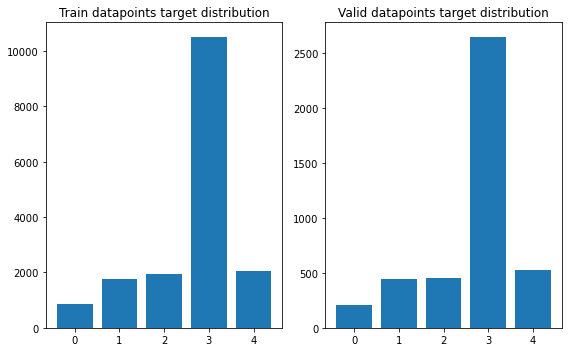

In [6]:
# Look at the distribution of counts of classes in the train and validation sets separately
fig, ax = plt.subplots(1, 2, figsize = (8, 5))

train_counts = df[~df.is_val].label.value_counts().to_dict()
valid_counts = df[df.is_val].label.value_counts().to_dict()

ax[0].bar(train_counts.keys(), train_counts.values())
ax[1].bar(valid_counts.keys(), valid_counts.values())

ax[0].set_title("Train datapoints target distribution")
ax[1].set_title("Valid datapoints target distribution")
fig.tight_layout()

In [7]:
# Define datablock for our dataset
validation_indices = df[df['is_val']].index.values

db = DataBlock((ImageBlock, CategoryBlock),
               get_x = ColReader("image_id", pref = trainPath),
               get_y = ColReader("label"),
               splitter = IndexSplitter(validation_indices),
               item_tfms = Resize(460),
               batch_tfms = aug_transforms(size = 225)
               )

In [8]:
# Create dataloaders out of the above template
cassava_dls = db.dataloaders(df, bs = 32)

In [9]:
# Look at the train and validation files lengths
len(cassava_dls.train_ds), len(cassava_dls.valid_ds)

(17118, 4279)

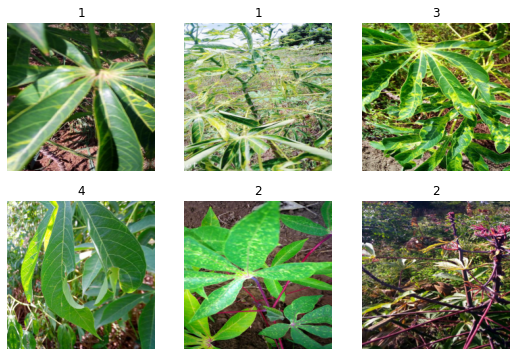

In [18]:
# Check if data is loaded properly
cassava_dls.show_batch(max_n = 6)

# Baseline model

Minimum/10:	3.98e-03
Steepest point:	1.32e-06
Longest valley:	5.75e-04
Slide interval:	7.59e-03


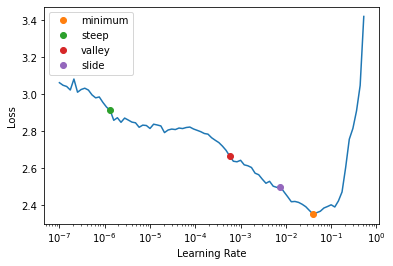

In [10]:
# Create a learner and find a good lr for our usecase
learn = cnn_learner(cassava_dls, resnet50, metrics = accuracy)
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f"Minimum/10:\t{lr_min:.2e}\nSteepest point:\t{lr_steep:.2e}\nLongest valley:\t{lr_valley:.2e}\nSlide interval:\t{lr_slide:.2e}")

In [14]:
learn.fit_one_cycle(3, 5.75e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.954160,0.738030,0.764431,04:42
1,0.692998,0.568168,0.802758,04:42
2,0.565079,0.533202,0.812807,04:43


Minimum/10:	1.45e-06
Steepest point:	5.75e-06
Longest valley:	3.98e-06
Slide interval:	3.63e-03


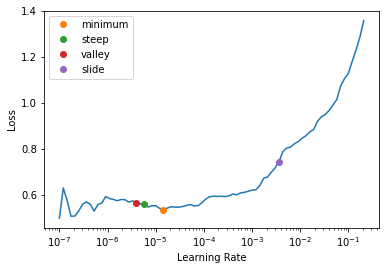

In [15]:
learn.unfreeze()
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f"Minimum/10:\t{lr_min:.2e}\nSteepest point:\t{lr_steep:.2e}\nLongest valley:\t{lr_valley:.2e}\nSlide interval:\t{lr_slide:.2e}")

In [18]:
learn.fit_one_cycle(5, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.581058,0.522153,0.817714,05:54
1,0.565649,0.509399,0.825193,05:57
2,0.555541,0.505575,0.826595,05:57
3,0.545068,0.503152,0.826361,06:00
4,0.540484,0.499861,0.827997,05:59


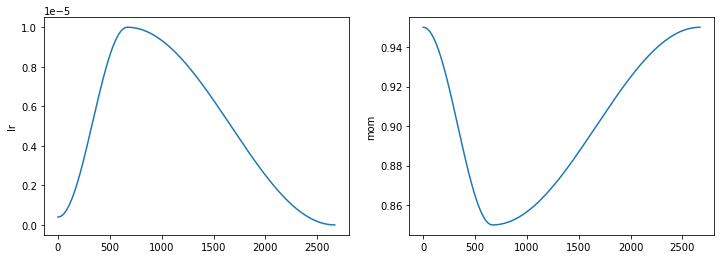

In [42]:
# Look at how the learning rate was varied throughout the 5 epochs
learn.recorder.plot_sched()

In [21]:
learn.export("baselineModel.pkl")

We obtained a baseline accuracy of ~83% on our train dataset. Now, we cannot/should not go any lower than this.

# Improving on the baseline

## Corrupt/Duplicate Image identification

Check if there's duplicates with different names but same image content

In [35]:
hashes, _ = utils.getHashes(trainPath)

In [40]:
def is_duplicate(x): return len(x) > 1
duplicate_hashes = filter_values(hashes, is_duplicate)
duplicate_hashes

{}

In [41]:
# Delete duplicate images 
for k, v in duplicate_hashes.items():
    duplicates = v[1:]
    for duplicate in duplicates:
        try:
            os.remove(os.path.join(trainPath, duplicate))
        except Exception as e:
            print(str(e), duplicate)
            pass

## Try a different variation of optimization method

Let us try the [`SGD with warm restarts`](https://docs.fast.ai/callback.schedule.html#Learner.fit_sgdr) method and tie in the fine_tune_sgdr method along with the learner as per [this tutorial](https://www.kaggle.com/muellerzr/cassava-fastai-starter).

In [11]:
@patch
def fine_tune_flat(self:Learner, epochs, base_lr=4e-3, freeze_epochs=1, lr_mult=100, pct_start=0.75, 
                   first_callbacks = [], second_callbacks = [], **kwargs):
    "Fine-tune applied to `fit_flat_cos`"
    self.freeze()
    self.fit_flat_cos(freeze_epochs, slice(base_lr), pct_start=0.99, cbs=first_callbacks, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_flat_cos(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, cbs=second_callbacks)

## Add mixup and label smoothing methods into the mix

In [12]:
cbs1 = [MixUp(alpha = 0.7)]
cbs2 = [MixUp(alpha = 0.3)]

## Normalization transform addition in the datablock

In [13]:
db_normalized = db.new(batch_tfms = [*aug_transforms(size = 256), Normalize.from_stats(*imagenet_stats)])
dls = db_normalized.dataloaders(df, bs = 32)

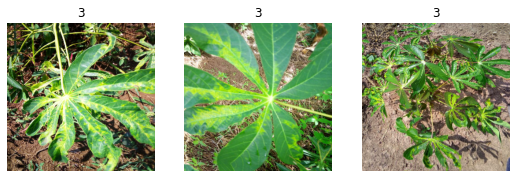

In [14]:
dls.show_batch(max_n = 3)

## Define a new learner and train using the custom fine tune method

In [15]:
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)

SuggestedLRs(valley=0.0020892962347716093)

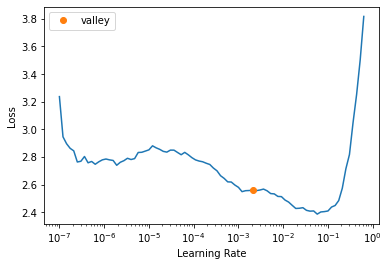

In [16]:
learn.lr_find()

In [17]:
learn.fine_tune_flat(freeze_epochs = 3, 
                     epochs = 5, 
                     first_callbacks = cbs1,
                     second_callbacks = cbs2,
                     base_lr = 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.160329,1.040046,0.715588,05:46
1,1.059118,0.870508,0.763730,05:42
2,1.037743,0.837338,0.785698,05:57


epoch,train_loss,valid_loss,accuracy,time
0,0.907643,0.797868,0.806497,06:54
1,0.895145,0.716321,0.851367,07:16
2,0.853509,0.700934,0.857911,07:12
3,0.842578,0.719723,0.847628,07:04
4,0.801554,0.664565,0.873569,06:46


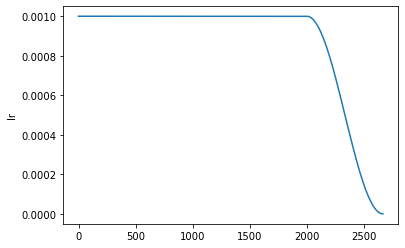

In [19]:
learn.recorder.plot_sched()